## Molecule odor prediction via GINs with self-supervised contrastive pretraining
*Stanford CS224W project by Sarah Chen, Matthew Ding, and Cathy Zhou*

In [1]:
# config settings 
use_pretraining = True 

### Installations

In [2]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ogb
!pip install pyrfume
!git clone https://github.com/paridhimaheshwari2708/GraphSSL.git

PyTorch has version 1.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-el65zxr4
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-el65zxr4
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit a8eca781a7ea5abf130095ccdaedd4129332415d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, ht

In [3]:
import torch_geometric
torch_geometric.__version__

'2.3.0'

In [4]:
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd

from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool

import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from tqdm import tqdm

torch_geometric.seed.seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# TODO: for now mount drive, but replace this with GitHub repo and %cd soon! 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'CS224W'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/CS224W/GNNose/src')
sys.path.append("/content/GraphSSL/")

Mounted at /content/drive


### Load the dataset

In [6]:
# load and split the dataset 
from odor_data import get_graph_data

graph_list = get_graph_data('lw')
train_set, val_set, test_set = torch.utils.data.random_split(graph_list, [0.7, 0.1, 0.2])

batch_size = 256 # TODO

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)


### Load the model

In [7]:
# set hyperparameters
in_channels = list(graph_list[2].x.shape)[-1]
out_channels = 1 # list(graph_list[2].y.shape)[1]
# TODO
hidden_channels = 64
num_layers = 1
dropout_p = 0.5
pooling_type = 'max'

In [19]:
# initialize model 
from odor_model import ScentClassifier

model = ScentClassifier(
    in_channels,
    hidden_channels, 
    num_layers, 
    out_channels,
    dropout=dropout_p,
    pooling_type=pooling_type,
)
model = model.to(device)

### Apply pretraining

# samples in train subset: 2466
# samples in val subset: 352


  1%|          | 1/120 [00:01<02:45,  1.39s/it]

Epoch 0, Train Loss: 5.351, Val Loss: 4.899


  2%|▏         | 2/120 [00:02<02:39,  1.35s/it]

Epoch 1, Train Loss: 5.328, Val Loss: 4.883


  2%|▎         | 3/120 [00:04<03:11,  1.64s/it]

Epoch 2, Train Loss: 5.303, Val Loss: 4.853


  3%|▎         | 4/120 [00:06<03:31,  1.82s/it]

Epoch 3, Train Loss: 5.276, Val Loss: 4.819


  4%|▍         | 5/120 [00:08<03:41,  1.92s/it]

Epoch 4, Train Loss: 5.246, Val Loss: 4.799


  5%|▌         | 6/120 [00:10<03:17,  1.73s/it]

Epoch 5, Train Loss: 5.216, Val Loss: 4.771


  6%|▌         | 7/120 [00:11<03:01,  1.60s/it]

Epoch 6, Train Loss: 5.184, Val Loss: 4.744


  7%|▋         | 8/120 [00:12<02:49,  1.51s/it]

Epoch 7, Train Loss: 5.148, Val Loss: 4.711


  8%|▊         | 9/120 [00:14<02:40,  1.45s/it]

Epoch 8, Train Loss: 5.116, Val Loss: 4.662


  8%|▊         | 10/120 [00:15<02:36,  1.42s/it]

Epoch 9, Train Loss: 5.082, Val Loss: 4.632


  9%|▉         | 11/120 [00:16<02:31,  1.39s/it]

Epoch 10, Train Loss: 5.048, Val Loss: 4.611


 10%|█         | 12/120 [00:18<02:29,  1.38s/it]

Epoch 11, Train Loss: 5.010, Val Loss: 4.551


 11%|█         | 13/120 [00:20<02:44,  1.54s/it]

Epoch 12, Train Loss: 4.975, Val Loss: 4.520


 12%|█▏        | 14/120 [00:22<03:01,  1.71s/it]

Epoch 13, Train Loss: 4.934, Val Loss: 4.475


 12%|█▎        | 15/120 [00:24<03:14,  1.85s/it]

Epoch 14, Train Loss: 4.895, Val Loss: 4.442


 13%|█▎        | 16/120 [00:25<02:55,  1.69s/it]

Epoch 15, Train Loss: 4.853, Val Loss: 4.398


 14%|█▍        | 17/120 [00:27<02:48,  1.64s/it]

Epoch 16, Train Loss: 4.805, Val Loss: 4.342


 15%|█▌        | 18/120 [00:28<02:37,  1.54s/it]

Epoch 17, Train Loss: 4.739, Val Loss: 4.250


 16%|█▌        | 19/120 [00:29<02:28,  1.47s/it]

Epoch 18, Train Loss: 4.628, Val Loss: 4.107


 17%|█▋        | 20/120 [00:31<02:24,  1.44s/it]

Epoch 19, Train Loss: 4.430, Val Loss: 3.871


 18%|█▊        | 21/120 [00:32<02:19,  1.40s/it]

Epoch 20, Train Loss: 4.246, Val Loss: 3.751


 18%|█▊        | 22/120 [00:33<02:15,  1.39s/it]

Epoch 21, Train Loss: 4.210, Val Loss: 3.744


 19%|█▉        | 23/120 [00:35<02:30,  1.55s/it]

Epoch 22, Train Loss: 4.194, Val Loss: 3.734


 20%|██        | 24/120 [00:38<02:45,  1.73s/it]

Epoch 23, Train Loss: 4.184, Val Loss: 3.707


 21%|██        | 25/120 [00:40<02:58,  1.88s/it]

Epoch 24, Train Loss: 4.159, Val Loss: 3.709


 22%|██▏       | 26/120 [00:41<02:42,  1.73s/it]

Epoch 25, Train Loss: 4.165, Val Loss: 3.711


 22%|██▎       | 27/120 [00:42<02:29,  1.61s/it]

Epoch 26, Train Loss: 4.162, Val Loss: 3.687


 23%|██▎       | 28/120 [00:44<02:20,  1.53s/it]

Epoch 27, Train Loss: 4.154, Val Loss: 3.712


 24%|██▍       | 29/120 [00:45<02:13,  1.47s/it]

Epoch 28, Train Loss: 4.159, Val Loss: 3.687


 25%|██▌       | 30/120 [00:46<02:09,  1.44s/it]

Epoch 29, Train Loss: 4.147, Val Loss: 3.699


 26%|██▌       | 31/120 [00:48<02:05,  1.41s/it]

Epoch 30, Train Loss: 4.144, Val Loss: 3.711


 27%|██▋       | 32/120 [00:49<02:02,  1.39s/it]

Epoch 31, Train Loss: 4.141, Val Loss: 3.689


 28%|██▊       | 33/120 [00:51<02:14,  1.55s/it]

Epoch 32, Train Loss: 4.152, Val Loss: 3.692


 28%|██▊       | 34/120 [00:53<02:29,  1.74s/it]

Epoch 33, Train Loss: 4.139, Val Loss: 3.661


 29%|██▉       | 35/120 [00:55<02:38,  1.87s/it]

Epoch 34, Train Loss: 4.130, Val Loss: 3.714


 30%|███       | 36/120 [00:57<02:27,  1.76s/it]

Epoch 35, Train Loss: 4.143, Val Loss: 3.657


 31%|███       | 37/120 [00:58<02:15,  1.64s/it]

Epoch 36, Train Loss: 4.125, Val Loss: 3.647


 32%|███▏      | 38/120 [01:00<02:05,  1.54s/it]

Epoch 37, Train Loss: 4.125, Val Loss: 3.649


 32%|███▎      | 39/120 [01:01<02:00,  1.48s/it]

Epoch 38, Train Loss: 4.126, Val Loss: 3.653


 33%|███▎      | 40/120 [01:02<01:55,  1.44s/it]

Epoch 39, Train Loss: 4.120, Val Loss: 3.660


 34%|███▍      | 41/120 [01:04<01:51,  1.41s/it]

Epoch 40, Train Loss: 4.125, Val Loss: 3.645


 35%|███▌      | 42/120 [01:05<01:47,  1.38s/it]

Epoch 41, Train Loss: 4.115, Val Loss: 3.643


 36%|███▌      | 43/120 [01:07<01:58,  1.54s/it]

Epoch 42, Train Loss: 4.112, Val Loss: 3.656


 37%|███▋      | 44/120 [01:09<02:10,  1.72s/it]

Epoch 43, Train Loss: 4.114, Val Loss: 3.651


 38%|███▊      | 45/120 [01:11<02:18,  1.85s/it]

Epoch 44, Train Loss: 4.122, Val Loss: 3.647


 38%|███▊      | 46/120 [01:13<02:05,  1.70s/it]

Epoch 45, Train Loss: 4.110, Val Loss: 3.663


 39%|███▉      | 47/120 [01:14<01:56,  1.59s/it]

Epoch 46, Train Loss: 4.110, Val Loss: 3.645


 40%|████      | 48/120 [01:15<01:49,  1.51s/it]

Epoch 47, Train Loss: 4.112, Val Loss: 3.661


 41%|████      | 49/120 [01:17<01:44,  1.47s/it]

Epoch 48, Train Loss: 4.110, Val Loss: 3.634


 42%|████▏     | 50/120 [01:18<01:40,  1.43s/it]

Epoch 49, Train Loss: 4.115, Val Loss: 3.645


 42%|████▎     | 51/120 [01:19<01:36,  1.40s/it]

Epoch 50, Train Loss: 4.112, Val Loss: 3.673


 43%|████▎     | 52/120 [01:21<01:34,  1.39s/it]

Epoch 51, Train Loss: 4.102, Val Loss: 3.656


 44%|████▍     | 53/120 [01:23<01:44,  1.55s/it]

Epoch 52, Train Loss: 4.103, Val Loss: 3.623


 45%|████▌     | 54/120 [01:25<01:53,  1.73s/it]

Epoch 53, Train Loss: 4.099, Val Loss: 3.647


 46%|████▌     | 55/120 [01:27<01:59,  1.84s/it]

Epoch 54, Train Loss: 4.094, Val Loss: 3.597


 47%|████▋     | 56/120 [01:28<01:48,  1.69s/it]

Epoch 55, Train Loss: 4.092, Val Loss: 3.610


 48%|████▊     | 57/120 [01:29<01:39,  1.58s/it]

Epoch 56, Train Loss: 4.098, Val Loss: 3.642


 48%|████▊     | 58/120 [01:31<01:33,  1.51s/it]

Epoch 57, Train Loss: 4.092, Val Loss: 3.624


 49%|████▉     | 59/120 [01:32<01:29,  1.46s/it]

Epoch 58, Train Loss: 4.095, Val Loss: 3.622


 50%|█████     | 60/120 [01:33<01:25,  1.42s/it]

Epoch 59, Train Loss: 4.088, Val Loss: 3.602


 51%|█████     | 61/120 [01:35<01:22,  1.40s/it]

Epoch 60, Train Loss: 4.093, Val Loss: 3.625


 52%|█████▏    | 62/120 [01:36<01:20,  1.38s/it]

Epoch 61, Train Loss: 4.088, Val Loss: 3.615


 52%|█████▎    | 63/120 [01:38<01:26,  1.52s/it]

Epoch 62, Train Loss: 4.086, Val Loss: 3.630


 53%|█████▎    | 64/120 [01:40<01:35,  1.70s/it]

Epoch 63, Train Loss: 4.090, Val Loss: 3.610


 54%|█████▍    | 65/120 [01:42<01:42,  1.86s/it]

Epoch 64, Train Loss: 4.082, Val Loss: 3.625


 55%|█████▌    | 66/120 [01:44<01:31,  1.70s/it]

Epoch 65, Train Loss: 4.083, Val Loss: 3.636


 56%|█████▌    | 67/120 [01:45<01:23,  1.58s/it]

Epoch 66, Train Loss: 4.090, Val Loss: 3.616


 57%|█████▋    | 68/120 [01:46<01:18,  1.51s/it]

Epoch 67, Train Loss: 4.079, Val Loss: 3.602


 57%|█████▊    | 69/120 [01:48<01:14,  1.45s/it]

Epoch 68, Train Loss: 4.079, Val Loss: 3.618


 58%|█████▊    | 70/120 [01:49<01:10,  1.41s/it]

Epoch 69, Train Loss: 4.073, Val Loss: 3.596


 59%|█████▉    | 71/120 [01:50<01:08,  1.39s/it]

Epoch 70, Train Loss: 4.076, Val Loss: 3.631


 60%|██████    | 72/120 [01:52<01:06,  1.38s/it]

Epoch 71, Train Loss: 4.075, Val Loss: 3.650


 61%|██████    | 73/120 [01:53<01:10,  1.49s/it]

Epoch 72, Train Loss: 4.080, Val Loss: 3.605


 62%|██████▏   | 74/120 [01:55<01:16,  1.66s/it]

Epoch 73, Train Loss: 4.075, Val Loss: 3.624


 62%|██████▎   | 75/120 [01:58<01:23,  1.85s/it]

Epoch 74, Train Loss: 4.075, Val Loss: 3.605


 63%|██████▎   | 76/120 [01:59<01:15,  1.72s/it]

Epoch 75, Train Loss: 4.068, Val Loss: 3.599


 64%|██████▍   | 77/120 [02:01<01:10,  1.64s/it]

Epoch 76, Train Loss: 4.070, Val Loss: 3.629


 65%|██████▌   | 78/120 [02:02<01:05,  1.55s/it]

Epoch 77, Train Loss: 4.067, Val Loss: 3.627


 66%|██████▌   | 79/120 [02:03<01:00,  1.48s/it]

Epoch 78, Train Loss: 4.066, Val Loss: 3.619


 67%|██████▋   | 80/120 [02:05<00:57,  1.43s/it]

Epoch 79, Train Loss: 4.058, Val Loss: 3.595


 68%|██████▊   | 81/120 [02:06<00:54,  1.40s/it]

Epoch 80, Train Loss: 4.063, Val Loss: 3.602


 68%|██████▊   | 82/120 [02:07<00:52,  1.38s/it]

Epoch 81, Train Loss: 4.062, Val Loss: 3.605


 69%|██████▉   | 83/120 [02:09<00:55,  1.49s/it]

Epoch 82, Train Loss: 4.062, Val Loss: 3.604


 70%|███████   | 84/120 [02:11<01:00,  1.67s/it]

Epoch 83, Train Loss: 4.059, Val Loss: 3.594


 71%|███████   | 85/120 [02:13<01:05,  1.86s/it]

Epoch 84, Train Loss: 4.071, Val Loss: 3.605


 72%|███████▏  | 86/120 [02:15<00:58,  1.72s/it]

Epoch 85, Train Loss: 4.063, Val Loss: 3.585


 72%|███████▎  | 87/120 [02:16<00:52,  1.59s/it]

Epoch 86, Train Loss: 4.050, Val Loss: 3.585


 73%|███████▎  | 88/120 [02:17<00:48,  1.52s/it]

Epoch 87, Train Loss: 4.049, Val Loss: 3.587


 74%|███████▍  | 89/120 [02:19<00:45,  1.47s/it]

Epoch 88, Train Loss: 4.054, Val Loss: 3.596


 75%|███████▌  | 90/120 [02:20<00:42,  1.43s/it]

Epoch 89, Train Loss: 4.056, Val Loss: 3.572


 76%|███████▌  | 91/120 [02:21<00:40,  1.39s/it]

Epoch 90, Train Loss: 4.043, Val Loss: 3.584


 77%|███████▋  | 92/120 [02:23<00:38,  1.37s/it]

Epoch 91, Train Loss: 4.052, Val Loss: 3.582


 78%|███████▊  | 93/120 [02:24<00:38,  1.44s/it]

Epoch 92, Train Loss: 4.054, Val Loss: 3.574


 78%|███████▊  | 94/120 [02:26<00:42,  1.63s/it]

Epoch 93, Train Loss: 4.048, Val Loss: 3.561


 79%|███████▉  | 95/120 [02:29<00:45,  1.82s/it]

Epoch 94, Train Loss: 4.048, Val Loss: 3.614


 80%|████████  | 96/120 [02:30<00:41,  1.74s/it]

Epoch 95, Train Loss: 4.038, Val Loss: 3.596


 81%|████████  | 97/120 [02:32<00:37,  1.62s/it]

Epoch 96, Train Loss: 4.043, Val Loss: 3.599


 82%|████████▏ | 98/120 [02:33<00:34,  1.55s/it]

Epoch 97, Train Loss: 4.043, Val Loss: 3.572


 82%|████████▎ | 99/120 [02:34<00:31,  1.49s/it]

Epoch 98, Train Loss: 4.042, Val Loss: 3.588


 83%|████████▎ | 100/120 [02:36<00:28,  1.44s/it]

Epoch 99, Train Loss: 4.036, Val Loss: 3.553


 84%|████████▍ | 101/120 [02:37<00:27,  1.45s/it]

Epoch 100, Train Loss: 4.039, Val Loss: 3.566


 85%|████████▌ | 102/120 [02:39<00:25,  1.42s/it]

Epoch 101, Train Loss: 4.040, Val Loss: 3.572


 86%|████████▌ | 103/120 [02:40<00:25,  1.52s/it]

Epoch 102, Train Loss: 4.028, Val Loss: 3.558


 87%|████████▋ | 104/120 [02:42<00:27,  1.69s/it]

Epoch 103, Train Loss: 4.032, Val Loss: 3.573


 88%|████████▊ | 105/120 [02:45<00:28,  1.88s/it]

Epoch 104, Train Loss: 4.027, Val Loss: 3.547


 88%|████████▊ | 106/120 [02:46<00:24,  1.76s/it]

Epoch 105, Train Loss: 4.012, Val Loss: 3.582


 89%|████████▉ | 107/120 [02:47<00:21,  1.63s/it]

Epoch 106, Train Loss: 4.007, Val Loss: 3.547


 90%|█████████ | 108/120 [02:49<00:18,  1.54s/it]

Epoch 107, Train Loss: 3.981, Val Loss: 3.509


 91%|█████████ | 109/120 [02:50<00:16,  1.48s/it]

Epoch 108, Train Loss: 3.953, Val Loss: 3.490


 92%|█████████▏| 110/120 [02:51<00:14,  1.44s/it]

Epoch 109, Train Loss: 3.957, Val Loss: 3.528


 92%|█████████▎| 111/120 [02:53<00:12,  1.41s/it]

Epoch 110, Train Loss: 3.943, Val Loss: 3.476


 93%|█████████▎| 112/120 [02:54<00:11,  1.39s/it]

Epoch 111, Train Loss: 3.945, Val Loss: 3.483


 94%|█████████▍| 113/120 [02:56<00:10,  1.47s/it]

Epoch 112, Train Loss: 3.935, Val Loss: 3.485


 95%|█████████▌| 114/120 [02:58<00:09,  1.65s/it]

Epoch 113, Train Loss: 3.933, Val Loss: 3.471


 96%|█████████▌| 115/120 [03:00<00:09,  1.84s/it]

Epoch 114, Train Loss: 3.939, Val Loss: 3.499


 97%|█████████▋| 116/120 [03:02<00:06,  1.74s/it]

Epoch 115, Train Loss: 3.931, Val Loss: 3.500


 98%|█████████▊| 117/120 [03:03<00:04,  1.63s/it]

Epoch 116, Train Loss: 3.924, Val Loss: 3.487


 98%|█████████▊| 118/120 [03:04<00:03,  1.54s/it]

Epoch 117, Train Loss: 3.940, Val Loss: 3.469


 99%|█████████▉| 119/120 [03:06<00:01,  1.48s/it]

Epoch 118, Train Loss: 3.925, Val Loss: 3.497


100%|██████████| 120/120 [03:07<00:00,  1.56s/it]

Epoch 119, Train Loss: 3.941, Val Loss: 3.487


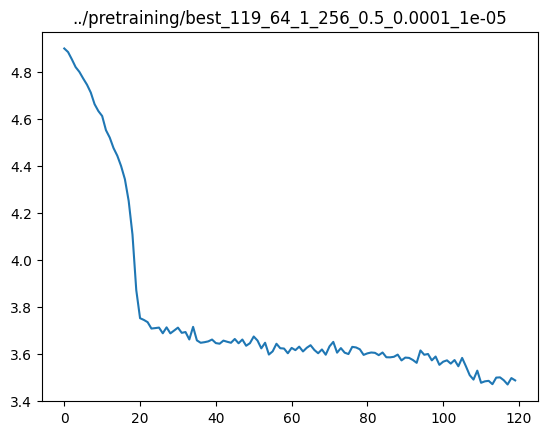

In [20]:
# apply pretraining 
if use_pretraining:
    from odor_pretrain import build_pretraining_loader, pretrain
    from odor_model import PretrainingGIN
    
    pretrain_epochs = 120
    pretrain_batch_size = 256
    pretrain_lr = 1e-4
    pretrain_weight_decay = 1e-5

    pretrain_train_loader = build_pretraining_loader(train_set, "train", batch_size=batch_size)
    pretrain_val_loader = build_pretraining_loader(val_set, "val", batch_size=batch_size)

    pretrain_model = PretrainingGIN(
        in_channels, 
        hidden_channels, 
        num_layers, 
        out_channels,
        dropout=dropout_p
    ).to(device)

    pretrain_optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=pretrain_lr, weight_decay=pretrain_weight_decay)

    val_losses = []
    for epoch in tqdm(range(pretrain_epochs)):
        train_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "train", pretrain_train_loader, device)
        val_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "val", pretrain_val_loader, device)
        log = "Epoch {}, Train Loss: {:.3f}, Val Loss: {:.3f}"
        print(log.format(epoch, train_loss, val_loss))

        val_losses.append(val_loss)
    plt.plot(range(len(val_losses)), val_losses)
    plt.title(f"../pretraining/best_{epoch}_{hidden_channels}_{num_layers}_{batch_size}_{dropout_p}_{pretrain_lr}_{pretrain_weight_decay}")
    plt.show()


    model.gnn.load_state_dict(
        pretrain_model.gnn.state_dict()
    )


### Finetune on labeled data

  2%|▏         | 1/60 [00:00<00:19,  3.07it/s]

Epoch 0, Loss 0.040288806831749686


  3%|▎         | 2/60 [00:00<00:18,  3.20it/s]

Epoch 1, Loss 0.03828838213806895


  5%|▌         | 3/60 [00:00<00:17,  3.23it/s]

Epoch 2, Loss 0.03811069010528045


  7%|▋         | 4/60 [00:01<00:17,  3.13it/s]

Epoch 3, Loss 0.03704132264161245


  8%|▊         | 5/60 [00:01<00:17,  3.08it/s]

Epoch 4, Loss 0.036224382057097125


 10%|█         | 6/60 [00:01<00:17,  3.12it/s]

Epoch 5, Loss 0.035225715660410786


 12%|█▏        | 7/60 [00:02<00:17,  3.09it/s]

Epoch 6, Loss 0.034818799923032835


 13%|█▎        | 8/60 [00:02<00:16,  3.13it/s]

Epoch 7, Loss 0.03383284841044009


 15%|█▌        | 9/60 [00:02<00:16,  3.18it/s]

Epoch 8, Loss 0.03265778494383974


 17%|█▋        | 10/60 [00:03<00:15,  3.27it/s]

Epoch 9, Loss 0.032731414518023735


 18%|█▊        | 11/60 [00:03<00:17,  2.84it/s]

Epoch 10, Loss 0.03191575072010842


 20%|██        | 12/60 [00:04<00:19,  2.51it/s]

Epoch 11, Loss 0.03290212241402508


 22%|██▏       | 13/60 [00:04<00:20,  2.33it/s]

Epoch 12, Loss 0.032905578226552004


 23%|██▎       | 14/60 [00:05<00:20,  2.21it/s]

Epoch 13, Loss 0.031512641752046586


 25%|██▌       | 15/60 [00:05<00:20,  2.15it/s]

Epoch 14, Loss 0.03216334773772921


 27%|██▋       | 16/60 [00:06<00:20,  2.10it/s]

Epoch 15, Loss 0.032883250220268605


 28%|██▊       | 17/60 [00:06<00:20,  2.06it/s]

Epoch 16, Loss 0.03150273394217263


 30%|███       | 18/60 [00:07<00:20,  2.03it/s]

Epoch 17, Loss 0.032319883167115246


 32%|███▏      | 19/60 [00:07<00:20,  2.01it/s]

Epoch 18, Loss 0.03237776396628424


 33%|███▎      | 20/60 [00:08<00:20,  2.00it/s]

Epoch 19, Loss 0.030575950457038478


 35%|███▌      | 21/60 [00:08<00:19,  1.99it/s]

Epoch 20, Loss 0.03139047108330769


 37%|███▋      | 22/60 [00:09<00:18,  2.01it/s]

Epoch 21, Loss 0.030722691194854514


 38%|███▊      | 23/60 [00:09<00:16,  2.26it/s]

Epoch 22, Loss 0.030199620362132522


 40%|████      | 24/60 [00:09<00:14,  2.47it/s]

Epoch 23, Loss 0.029816347510468542


 42%|████▏     | 25/60 [00:10<00:13,  2.66it/s]

Epoch 24, Loss 0.03022476665778365


 43%|████▎     | 26/60 [00:10<00:12,  2.79it/s]

Epoch 25, Loss 0.03070705225094488


 45%|████▌     | 27/60 [00:10<00:11,  2.91it/s]

Epoch 26, Loss 0.029132103011169187


 47%|████▋     | 28/60 [00:11<00:10,  3.00it/s]

Epoch 27, Loss 0.030694221348078


 48%|████▊     | 29/60 [00:11<00:10,  3.09it/s]

Epoch 28, Loss 0.02967771493798818


 50%|█████     | 30/60 [00:11<00:09,  3.11it/s]

Epoch 29, Loss 0.027252843876921444


 52%|█████▏    | 31/60 [00:11<00:09,  3.04it/s]

Epoch 30, Loss 0.027976212420312736


 53%|█████▎    | 32/60 [00:12<00:09,  3.08it/s]

Epoch 31, Loss 0.028980595448688095


 55%|█████▌    | 33/60 [00:12<00:08,  3.02it/s]

Epoch 32, Loss 0.02960826319983019


 57%|█████▋    | 34/60 [00:12<00:08,  3.07it/s]

Epoch 33, Loss 0.029210466344667854


 58%|█████▊    | 35/60 [00:13<00:08,  3.12it/s]

Epoch 34, Loss 0.029654765651173837


 60%|██████    | 36/60 [00:13<00:07,  3.15it/s]

Epoch 35, Loss 0.03146947252005943


 62%|██████▏   | 37/60 [00:13<00:07,  3.15it/s]

Epoch 36, Loss 0.030946196720837968


 63%|██████▎   | 38/60 [00:14<00:07,  3.11it/s]

Epoch 37, Loss 0.030736780321317676


 65%|██████▌   | 39/60 [00:14<00:06,  3.13it/s]

Epoch 38, Loss 0.028516458672231904


 67%|██████▋   | 40/60 [00:14<00:06,  3.12it/s]

Epoch 39, Loss 0.030077616180333295


 68%|██████▊   | 41/60 [00:15<00:06,  3.16it/s]

Epoch 40, Loss 0.032451267660099224


 70%|███████   | 42/60 [00:15<00:05,  3.18it/s]

Epoch 41, Loss 0.030212314169482304


 72%|███████▏  | 43/60 [00:15<00:05,  3.17it/s]

Epoch 42, Loss 0.029013003746088405


 73%|███████▎  | 44/60 [00:16<00:04,  3.22it/s]

Epoch 43, Loss 0.028492747528806317


 75%|███████▌  | 45/60 [00:16<00:04,  3.20it/s]

Epoch 44, Loss 0.027910369059368546


 77%|███████▋  | 46/60 [00:16<00:04,  3.17it/s]

Epoch 45, Loss 0.026984715790450815


 78%|███████▊  | 47/60 [00:17<00:04,  3.19it/s]

Epoch 46, Loss 0.028185559788662926


 80%|████████  | 48/60 [00:17<00:03,  3.21it/s]

Epoch 47, Loss 0.026130030625057917


 82%|████████▏ | 49/60 [00:17<00:03,  3.23it/s]

Epoch 48, Loss 0.027727484799746276


 83%|████████▎ | 50/60 [00:17<00:03,  3.25it/s]

Epoch 49, Loss 0.028013067910657698


 85%|████████▌ | 51/60 [00:18<00:02,  3.21it/s]

Epoch 50, Loss 0.027180813621527185


 87%|████████▋ | 52/60 [00:18<00:02,  3.25it/s]

Epoch 51, Loss 0.028597001031657496


 88%|████████▊ | 53/60 [00:18<00:02,  3.21it/s]

Epoch 52, Loss 0.02828940703244298


 90%|█████████ | 54/60 [00:19<00:01,  3.11it/s]

Epoch 53, Loss 0.029977961274925906


 92%|█████████▏| 55/60 [00:19<00:01,  2.64it/s]

Epoch 54, Loss 0.030710628529631405


 93%|█████████▎| 56/60 [00:20<00:01,  2.42it/s]

Epoch 55, Loss 0.02991280629203654


 95%|█████████▌| 57/60 [00:20<00:01,  2.28it/s]

Epoch 56, Loss 0.029308394117270268


 97%|█████████▋| 58/60 [00:21<00:00,  2.17it/s]

Epoch 57, Loss 0.028268388491380726


 98%|█████████▊| 59/60 [00:21<00:00,  2.11it/s]

Epoch 58, Loss 0.02794422372414248


100%|██████████| 60/60 [00:22<00:00,  2.69it/s]

Epoch 59, Loss 0.026547945715601814


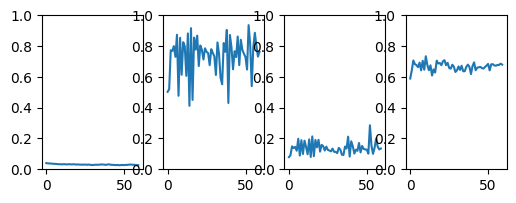

In [21]:
# train the model 
from odor_train import train, test

num_epochs = 60
lr = 0.001
weight_decay = 1e-5

roc_scores, f1_scores, accs, losses = [], [], [], []
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

roc_scores = []
for epoch in tqdm(range(num_epochs)):
    loss = train(model, optimizer, train_loader, device, weighted_BCE=True)
    train_acc, train_preds, train_true  = test(model, train_loader, device)
    test_acc, test_preds, test_true = test(model, test_loader, device)
    # log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
    log = "Epoch {}, Loss {}"
    print(log.format(epoch, loss))


    # bootrapped ROC AUC score over entire test set
    _, whole_test_preds, whole_test_true = test(
        model, DataLoader(test_set, batch_size=len(test_set), shuffle=True), device)
    whole_test_preds = whole_test_preds.squeeze()
    whole_test_true = whole_test_true.squeeze()
    rocauc_score = roc_auc_score(whole_test_true.cpu(), whole_test_preds.cpu())
    f1 = f1_score(whole_test_true.cpu(), whole_test_preds.cpu())

    roc_scores.append(rocauc_score)
    f1_scores.append(f1)
    accs.append(accuracy_score(whole_test_true.cpu(), whole_test_preds.cpu()))
    losses.append(loss)

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i, (name, metric) in enumerate([
    ('loss', losses), ('acc', accs), ('f1', f1_scores), ('roc', roc_scores)
]):
    ax[i].plot(range(len(metric)), metric)
    ax[i].set_ylim((0, 1))
